In [1]:
# Import des packages utiles au projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn import preprocessing as pp
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from graphviz import Source
from itertools import cycle
import seaborn as sns



In [2]:
#Fichiers à importer, à scorer et définition du répertoire pour la sauvegarde des résultats

URL_ADULT ='/Users/teriitehau/Desktop/2020-2021/Méthode_de_scoring/fraude_mobile_phone_ech/fraude_mobile_phone_ech_train.csv'
URL_ADULT_test ='/Users/teriitehau/Desktop/2020-2021/Méthode_de_scoring/fraude_mobile_phone_ech/fraude_mobile_phone_ech_test.csv'


dir_res = r'C:\Tanguy\Enseignement\IAE Nantes Master EKAP\Cours Fraude Python\results'


# Import du fichier adult.csv
df_train = pd.read_csv(URL_ADULT, skipinitialspace=True)
df_test = pd.read_csv(URL_ADULT_test, skipinitialspace=True)
stats_desc_dftrain = df_train.describe() #Description des variables quanti
stats_desc_dftest = df_test.describe() #Description des variables quanti


In [3]:
#vue nature des variables
print(df_train.info(), "\n")
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB
None 

(500000, 11)


In [4]:
#dimension des bases 
print(df_train.shape,
df_test.shape )


# Calcul du nombre de données manquantes par variable
nb_null_by_vartrain = np.sum(pd.isnull(df_train))
print(nb_null_by_vartrain)
nb_null_by_var_test = np.sum(pd.isnull(df_test))
print(nb_null_by_var_test)

#aucune valeur manquante 


(500000, 11) (250000, 11)
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
df_train.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:

df_train["echantillon"] = "train"
df_test["echantillon"] = "test"

frames= [df_train,df_test]
nrw_df = pd.concat(frames,axis=0)# 0 permet d'empiler par ligne

#régénerer index 
nrw_df = nrw_df.reset_index(drop=True)
 

#creation train et test_index (recup index des individus)
train_index = list(nrw_df[(nrw_df.echantillon=='train')].index)
train_index[:100]
test_index = list(nrw_df[(nrw_df.echantillon=='test')].index)
total = len(df_train)
total_amt = df_train.groupby(['isFraud'])['amount'].sum().sum()

In [7]:
#creation d'une variable
df_train['dest']=0
df_test['dest']= 0

df_train['dest']= df_train['nameDest'].str.split('(\d.+)', n = 0, expand = True)
df_test['dest']= df_test['nameDest'].str.split('(\d.+)', n = 0, expand = True)

In [8]:
#Les ind qui ont newbalanceOrig zero car la majorité de la fraude provient d'eux
#quand le destinaire est un C
df_train['Orig_newbal_zero_destC'] = 0
df_train.loc[(df_train['newbalanceOrig']==0) &
            (df_train['dest']=='C'),'Orig_newbal_zero_destC']=1

df_test['Orig_newbal_zero_destC'] = 0
df_test.loc[(df_test['newbalanceOrig']==0) &
            (df_test['dest']=='C'),'Orig_newbal_zero_destC']=1

In [9]:
pd.crosstab(df_train['Orig_newbal_zero_destC'], df_train['isFraud'])

isFraud,0,1
Orig_newbal_zero_destC,,
0,301619,4
1,198148,229


In [10]:
df_train['Erreur_orig']= df_train['newbalanceOrig']+df_train['amount']-df_train['oldbalanceOrg']
df_test['Erreur_orig']= df_test['newbalanceOrig']+df_test['amount']-df_test['oldbalanceOrg']


df_train['Erreur_dest']= df_train['oldbalanceDest']+df_train['amount']-df_train['newbalanceDest']
df_test['Erreur_dest']= df_test['oldbalanceDest']+df_test['amount']-df_test['newbalanceDest']

In [11]:
#df_train = df_train.drop(['CASH_OUT', 'TRANSFER'], axis=1) 
#df_test = df_test.drop(['CASH_OUT', 'TRANSFER'], axis=1)

In [12]:
#variable dummies 
dummy = pd.get_dummies(df_train['type'])
df_train = pd.concat([df_train, dummy], axis=1)

dummy = pd.get_dummies(df_train['dest'])
df_train = pd.concat([df_train, dummy], axis=1)


dummy = pd.get_dummies(df_test['type'])
df_test = pd.concat([df_test, dummy], axis=1)

dummy = pd.get_dummies(df_test['dest'])
df_test = pd.concat([df_test, dummy], axis=1)

In [13]:
df_test.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,Orig_newbal_zero_destC,Erreur_orig,Erreur_dest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,C,M
0,21,TRANSFER,100151.57,C525682612,11503.0,0.0,C825468375,0.0,100151.57,0,...,1,88648.57,0.0,0,0,0,0,1,1,0


In [14]:
#var qualitative
var_quali = ['CASH_OUT', 'TRANSFER','C']
df_train[var_quali] = df_train[var_quali].astype(int)
df_test[var_quali] = df_test[var_quali].astype(int)
#doit etre en int car le Xboost ne va pas fonctionner

In [15]:
#var_expli = ['step', 'amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
#            'old_compte_zero_dest','new_compte_zero_dest','OrigC_zero_dest','Orig_newbal_zero_destC',
#            'CASH_OUT','TRANSFER']
var_expli = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
            'CASH_OUT','TRANSFER','C','Erreur_orig','Erreur_dest']

target = ['isFraud']

X_train1= df_train[var_expli]
Y_train1= df_train[target]
X_test1 = df_test[var_expli]
Y_test1= df_test[target]

In [32]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

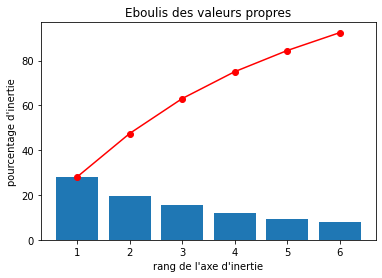

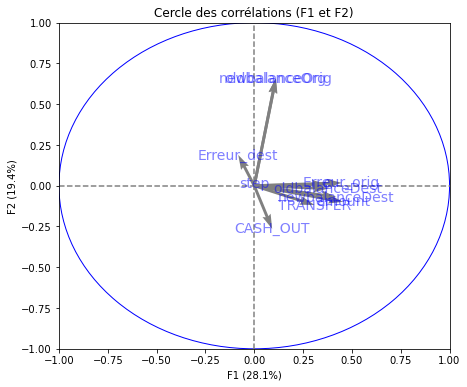

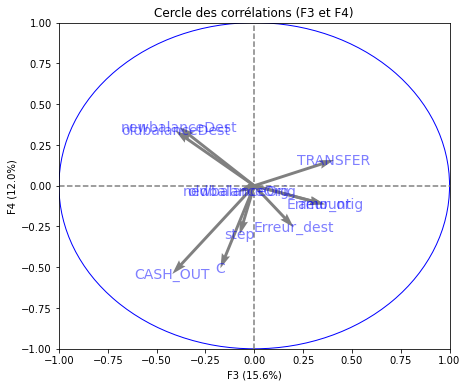

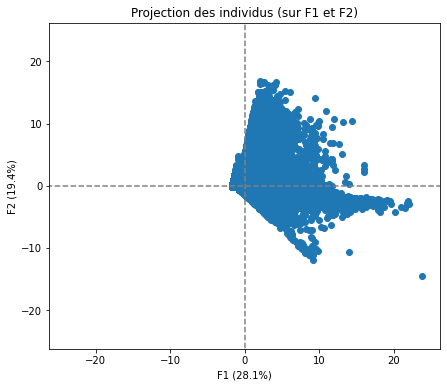

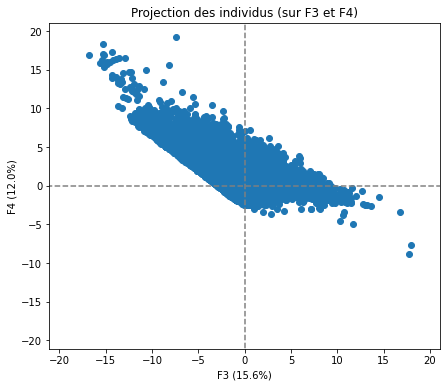

In [34]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
#from functions import *

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# choix du nombre de composantes à calculer
n_comp = 6

# import de l'échantillon
data = X_train1
# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[var_expli]
# préparation des données pour l'ACP
X = data_pca.values
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)])

plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
features= var_expli
# Separating out the features
x = df_train.loc[:, features].values
# Separating out the target
y = df_train.loc[:,['isFraud']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
df_train['isFraud1'] = 'No_fraud'
df_train.loc[(df_train['isFraud']==1 ,'isFraud1')]='Fraud'

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [53]:
finalDf = pd.concat([principalDf, df_train[['isFraud']]], axis = 1)
finalDf.head(3)

,principal component 1,principal component 2,isFraud
0,-1.646736,-0.059773,0
1,-1.669435,-0.122339,0
2,0.244614,-0.541651,1


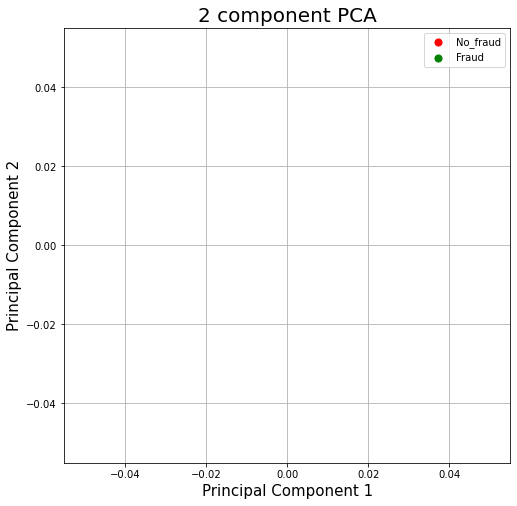

In [54]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['No_fraud', 'Fraud']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['isFraud'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

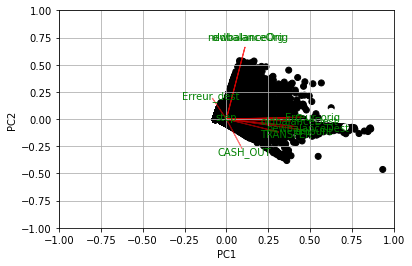

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_train['isFraud1'] = '0'
df_train.loc[(df_train['isFraud']==1 ,'isFraud1')]='1'

X = X_train1
y = df_train['isFraud1']
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=var_expli):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.figure(1, figsize=(5, 3))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [73]:
#pip install pca

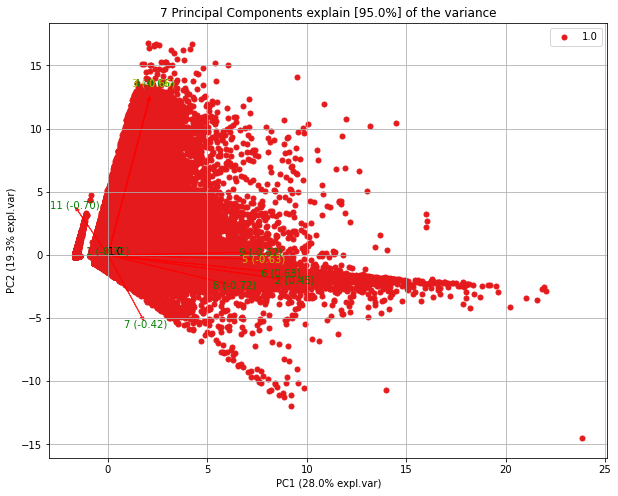

In [72]:
ax = model.biplot(n_feat=10, legend=True)

(500000, 2)


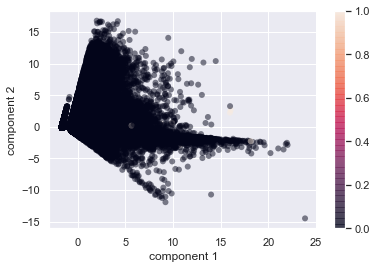

In [82]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
projected = pca.fit_transform(X)
y = df_train['isFraud']
print(projected.shape)
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [16]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score, precision_score
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
def perf(train_y,train_x,valid_y,valid_x,clf):
    print("Train F1-score : {}".format(f1_score(train_y, clf.predict(train_x).round(), average='macro')))
    print("Valid F1-score : {}".format(f1_score(valid_y, clf.predict(valid_x).round(), average='macro')))
    
    print("score AUC train : {}".format(roc_auc_score(train_y, clf.predict(train_x).round())))
    print("score AUC test : {}".format(roc_auc_score(valid_y, clf.predict(valid_x).round())))
    
    print("score Accuracy train : {}".format(accuracy_score(train_y, clf.predict(train_x).round())))
    print("score Accuracy test : {}".format(accuracy_score(valid_y, clf.predict(valid_x).round())))
    
    print("score Recall train : {}".format(recall_score(train_y, clf.predict(train_x).round())))
    print("score Recall test : {}".format(recall_score(valid_y, clf.predict(valid_x).round())))
    
    print("score Precision train : {}".format(precision_score(train_y, clf.predict(train_x).round())))
    print("score Precision test : {}".format(precision_score(valid_y, clf.predict(valid_x).round())))
    
    print("score Cohen train : {}".format(cohen_kappa_score(train_y, clf.predict(train_x).round())))
    print("score Cohen test : {}".format(cohen_kappa_score(valid_y, clf.predict(valid_x).round())))
    
    print(" matthews_corrcoef train : {}".format(matthews_corrcoef(train_y, clf.predict(train_x).round())))
    print("matthews_corrcoef Cohen test : {}".format(matthews_corrcoef(valid_y, clf.predict(valid_x).round())))
    

In [17]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [18]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train1, Y_train1)

DecisionTreeClassifier()

In [23]:
perf(Y_train1,X_train1,Y_test1,X_test1,clf_tree)

Train F1-score : 1.0
Valid F1-score : 0.9852477594989348
score AUC train : 1.0
score AUC test : 0.9841508853102161
score Accuracy train : 1.0
score Accuracy test : 0.999948
score Recall train : 1.0
score Recall test : 0.9683257918552036
score Precision train : 1.0
score Precision test : 0.9727272727272728
score Cohen train : 1.0
score Cohen test : 0.9704955191317948
 matthews_corrcoef train : 1.0
matthews_corrcoef Cohen test : 0.9704980186394275


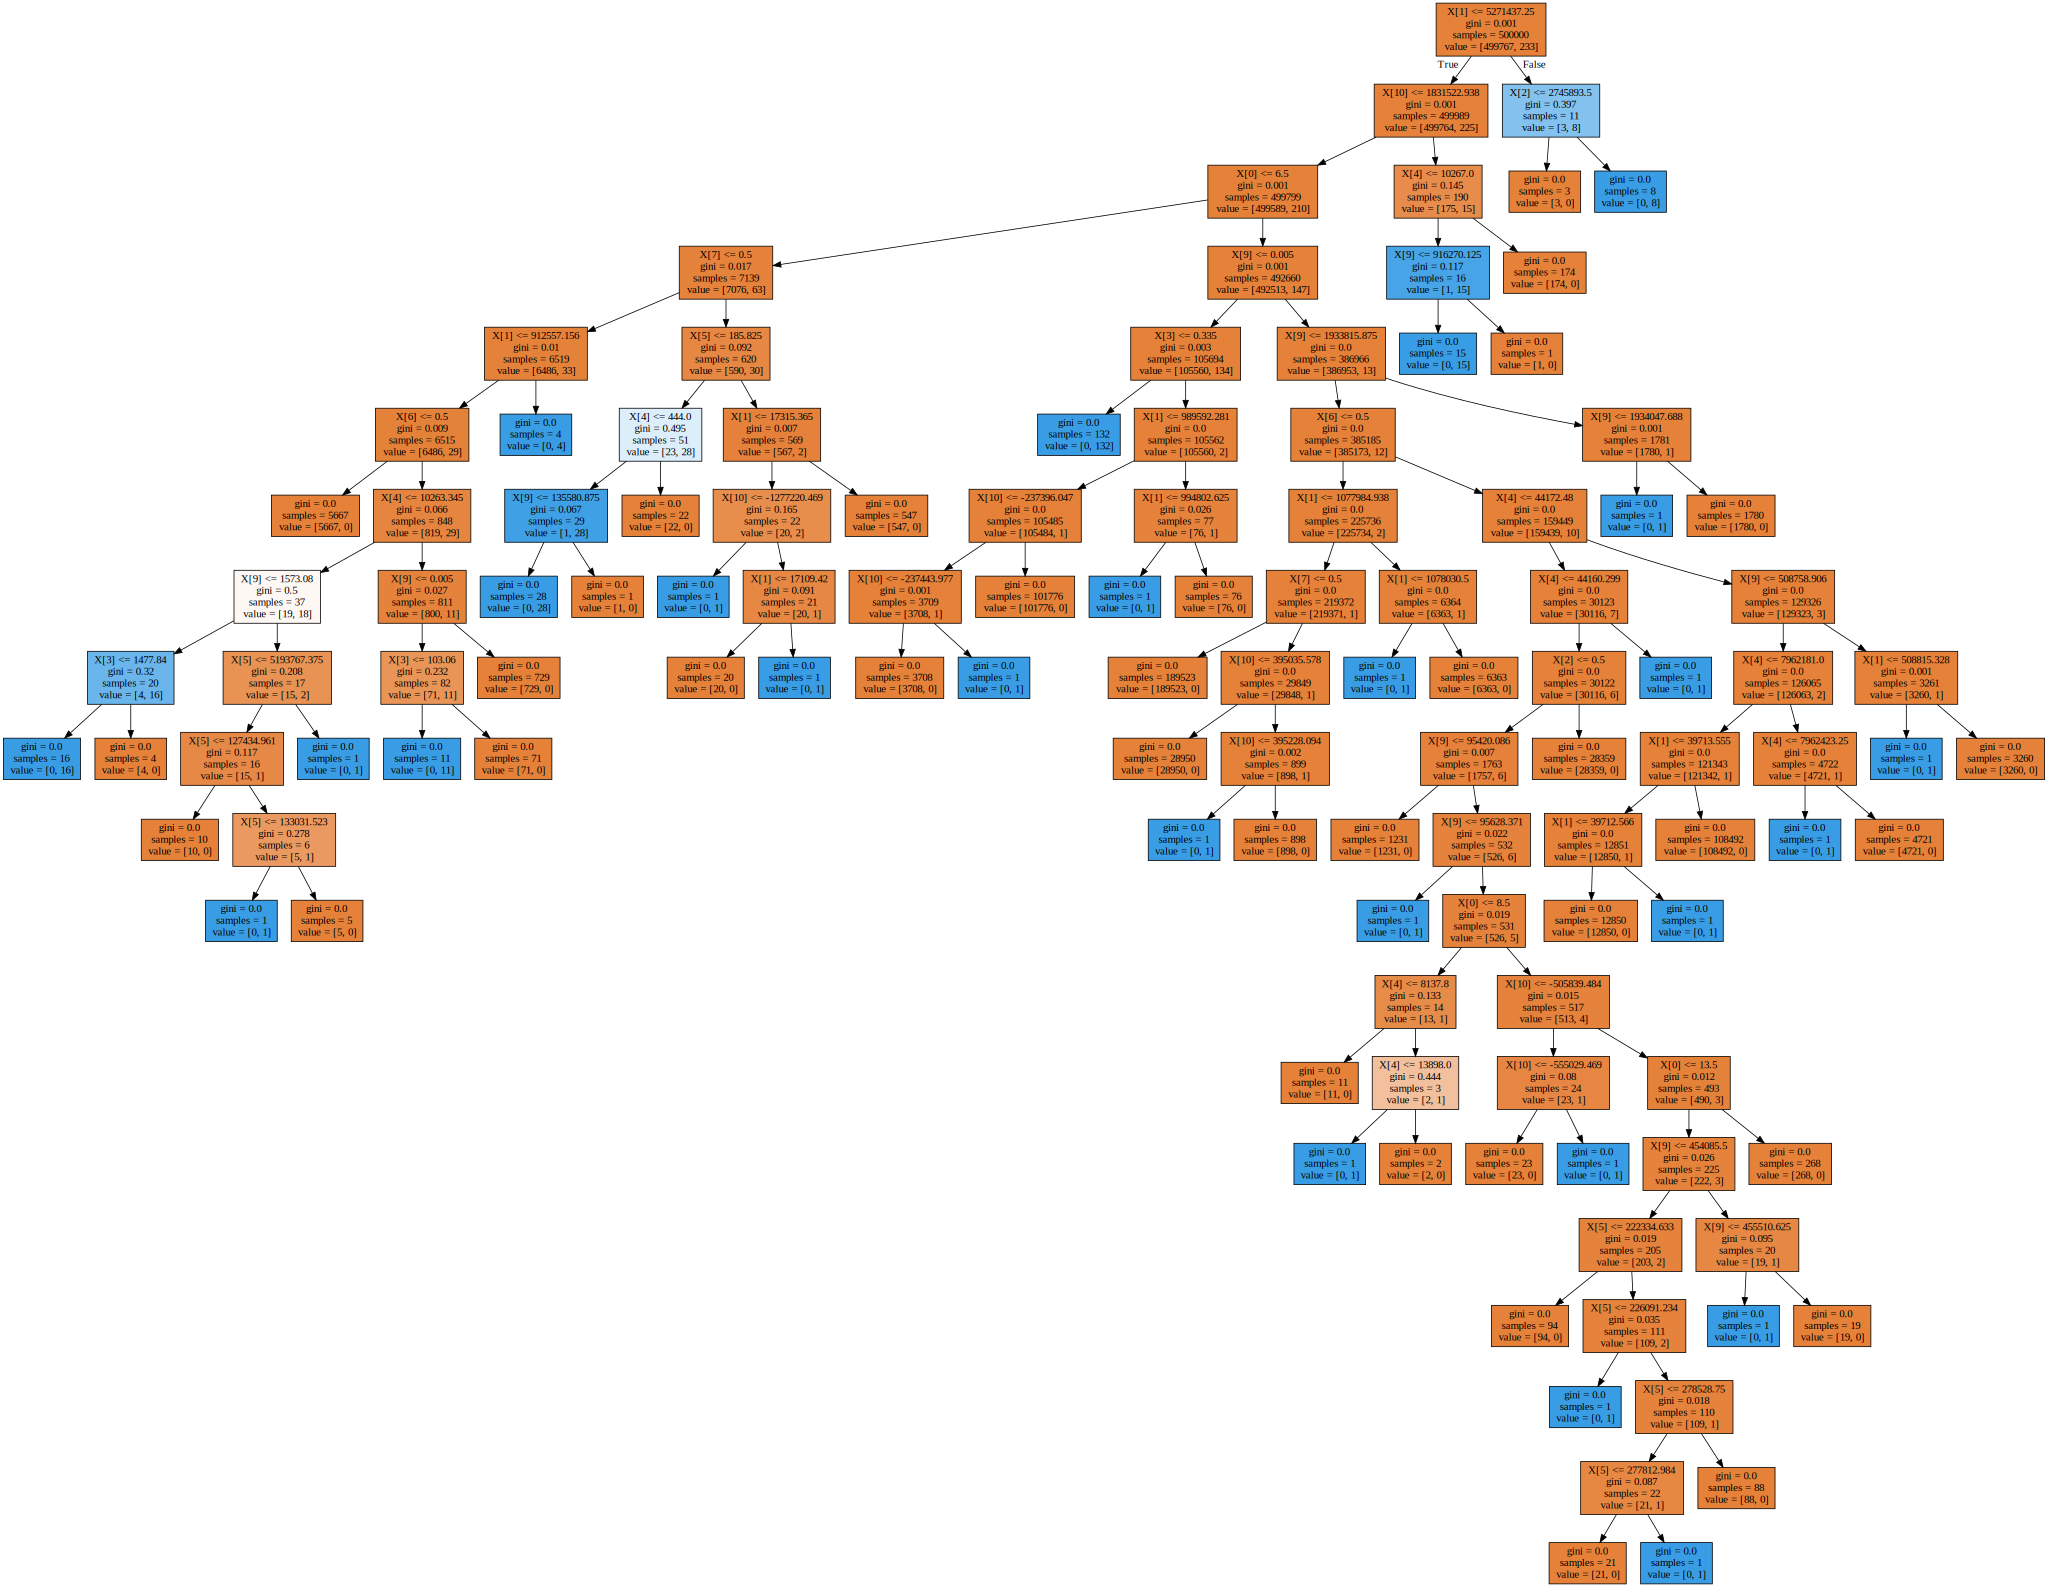

In [35]:
import graphviz as gv
import pylab
# DOT data
dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                                
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

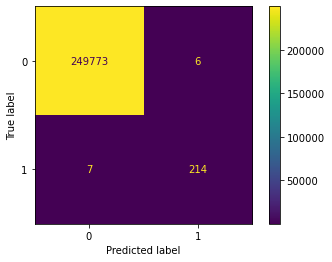

In [24]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_tree, X_test1, Y_test1) 

In [19]:
import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(X_train1, Y_train1)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:50:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
perf(Y_train1,X_train1,Y_test1,X_test1,boost)

Train F1-score : 0.996758758484444
Valid F1-score : 0.9919470168932027
score AUC train : 0.9935622317596566
score AUC test : 0.9841628959276019
score Accuracy train : 0.999994
score Accuracy test : 0.999972
score Recall train : 0.9871244635193133
score Recall test : 0.9683257918552036
score Precision train : 1.0
score Precision test : 1.0
score Cohen train : 0.9935175170949556
score Cohen test : 0.9838940374180349
 matthews_corrcoef train : 0.9935383928398615
matthews_corrcoef Cohen test : 0.9840216743061686


<Figure size 2880x1440 with 0 Axes>

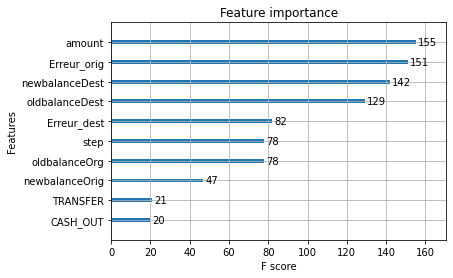

In [25]:
from xgboost import plot_importance
plt.figure(figsize=(40,20))
plot_importance(boost ,max_num_features=100)
plt.rcParams["figure.figsize"] = (20,100)
plt.show()

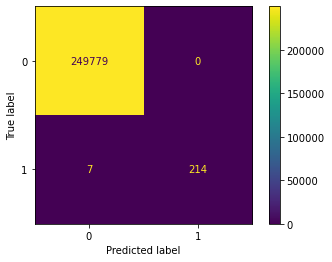

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(boost, X_test1, Y_test1) 

In [27]:
y_prob =boost.predict_proba(X_test1)
y_pred =boost.predict(X_test1)
y_pred = pd.DataFrame(y_pred)
y_prob = pd.DataFrame(y_prob)
df_test['Proba_boost']= y_prob[1]
matrice = confusion_matrix(Y_test1,y_pred)
print(matrice)


[[249779      0]
 [     7    214]]


In [28]:
df_test.loc[(y_pred[0]!=Y_test1['isFraud']),['step','type','amount',
                                            'oldbalanceOrg','newbalanceOrig',
                                            'oldbalanceDest','newbalanceDest','isFraud',
                                            'Erreur_orig','Erreur_dest','Proba_boost']]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Erreur_orig,Erreur_dest,Proba_boost
10820,21,CASH_OUT,23292.30,0.0,0.0,392364.62,415656.92,1,23292.30,0.00,0.000001
26871,22,CASH_OUT,89571.46,4505.6,0.0,1929428.01,2018999.47,1,85065.86,0.00,0.000005
110563,35,CASH_OUT,112280.88,0.0,0.0,40512.49,152793.36,1,112280.88,0.01,0.000956
161443,36,CASH_OUT,234377.29,0.0,0.0,34937.86,269315.15,1,234377.29,0.00,0.000321
199783,37,CASH_OUT,112486.46,0.0,0.0,257274.47,369760.93,1,112486.46,0.00,0.000002
217647,38,CASH_OUT,577418.98,0.0,0.0,0.00,577418.98,1,577418.98,0.00,0.001303
231079,38,CASH_OUT,407005.78,0.0,0.0,0.00,407005.78,1,407005.78,0.00,0.000492


In [29]:
df_test.sort_values(by=['Proba_boost'], ascending = False).head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,Erreur_orig,Erreur_dest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,C,M,Proba_boost
133919,36,CASH_OUT,2352524.18,C914179351,2352524.18,0.0,C413966770,1227902.12,3580426.31,1,...,0.0,-1.000000e-02,0,1,0,0,0,1,0,0.999930
43226,28,TRANSFER,3832058.34,C1279307827,3832058.34,0.0,C1124913173,0.00,0.00,1,...,0.0,3.832058e+06,0,0,0,0,1,1,0,0.999881
43256,32,TRANSFER,2023920.09,C306405849,2023920.09,0.0,C193080093,0.00,0.00,1,...,0.0,2.023920e+06,0,0,0,0,1,1,0,0.999881
22681,22,TRANSFER,2068118.36,C1472367087,2068118.36,0.0,C52390890,0.00,0.00,1,...,0.0,2.068118e+06,0,0,0,0,1,1,0,0.999881
133918,36,TRANSFER,2352524.18,C1498028072,2352524.18,0.0,C70360442,0.00,0.00,1,...,0.0,2.352524e+06,0,0,0,0,1,1,0,0.999881
47341,33,TRANSFER,3295227.84,C1152596026,3295227.84,0.0,C1976114093,0.00,0.00,1,...,0.0,3.295228e+06,0,0,0,0,1,1,0,0.999881
110327,35,TRANSFER,3606943.31,C1054903406,3606943.31,0.0,C755069790,0.00,0.00,1,...,0.0,3.606943e+06,0,0,0,0,1,1,0,0.999881
233519,39,TRANSFER,2070814.27,C511306069,2070814.27,0.0,C1776402146,0.00,0.00,1,...,0.0,2.070814e+06,0,0,0,0,1,1,0,0.999881
43227,28,CASH_OUT,3832058.34,C426880249,3832058.34,0.0,C1566081912,531662.14,4363720.48,1,...,0.0,-9.313226e-10,0,1,0,0,0,1,0,0.999836
43265,32,CASH_OUT,604933.67,C1085892947,604933.67,0.0,C1138178950,35839.70,640773.38,1,...,0.0,-1.000000e-02,0,1,0,0,0,1,0,0.999771


In [36]:
#modèle mois 1 
mois1_train = X_train1.loc[(df_train['step']==7) | (df_train['step']==8)|(df_train['step']==9)|
            (df_train['step']==10)|(df_train['step']==11)|(df_train['step']==12)]
mois1_Ytrain=Y_train1.loc[(df_train['step']==7) | (df_train['step']==8)|(df_train['step']==9)|
            (df_train['step']==10)|(df_train['step']==11)|(df_train['step']==12)]

mois1_test = X_train1.loc[df_train['step']==16]
mois1_Ytest=Y_train1.loc[df_train['step']==16]

mois1_Xtrain= mois1_train[var_expli]
mois1_Xtest = mois1_test[var_expli]

import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(mois1_Xtrain, mois1_Ytrain)

perf(mois1_Ytrain,mois1_Xtrain,mois1_Ytest,mois1_Xtest,boost)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:55:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1-score : 0.9966428656890096
Valid F1-score : 0.9761845883653211
score AUC train : 0.9933333333333334
score AUC test : 0.999988224488354
score Accuracy train : 0.9999942839831492
score Accuracy test : 0.9999764545219091
score Recall train : 0.9866666666666667
score Recall test : 1.0
score Precision train : 1.0
score Precision test : 0.9090909090909091
score Cohen train : 0.9932857315068624
score Cohen test : 0.9523692034393851
 matthews_corrcoef train : 0.9933081216202808
matthews_corrcoef Cohen test : 0.9534513616696629


In [37]:
#modèle mois 2 
mois1_train = X_train1.loc[(df_train['step']==8) | (df_train['step']==9)|(df_train['step']==10)|
            (df_train['step']==11)|(df_train['step']==12)|(df_train['step']==13)]
mois1_Ytrain=Y_train1.loc[(df_train['step']==8) | (df_train['step']==9)|(df_train['step']==10)|
            (df_train['step']==11)|(df_train['step']==12)|(df_train['step']==13)]

mois1_test = X_train1.loc[df_train['step']==17]
mois1_Ytest=Y_train1.loc[df_train['step']==17]

mois1_Xtrain= mois1_train[var_expli]
mois1_Xtest = mois1_test[var_expli]
boost.fit(mois1_Xtrain, mois1_Ytrain)

perf(mois1_Ytrain,mois1_Xtrain,mois1_Ytest,mois1_Xtest,boost)


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:55:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1-score : 0.9967308098858274
Valid F1-score : 0.9615326951243637
score AUC train : 0.9935064935064934
score AUC test : 0.9285714285714286
score Accuracy train : 0.9999951367781155
score Accuracy test : 0.99997693780125
score Recall train : 0.987012987012987
score Recall test : 0.8571428571428571
score Precision train : 1.0
score Precision test : 1.0
score Cohen train : 0.9934616198756072
score Cohen test : 0.9230654585004853
 matthews_corrcoef train : 0.9934828560045944
matthews_corrcoef Cohen test : 0.9258094225099701


In [38]:
#modèle mois 3
mois1_train = X_train1.loc[(df_train['step']==9) | (df_train['step']==10)|(df_train['step']==11)|
            (df_train['step']==12)|(df_train['step']==13)|(df_train['step']==14)]
mois1_Ytrain=Y_train1.loc[(df_train['step']==9) | (df_train['step']==10)|(df_train['step']==11)|
            (df_train['step']==12)|(df_train['step']==13)|(df_train['step']==14)]
mois1_test = X_train1.loc[df_train['step']==18]
mois1_Ytest=Y_train1.loc[df_train['step']==18]
mois1_Xtrain= mois1_train[var_expli]
mois1_Xtest = mois1_test[var_expli]
boost.fit(mois1_Xtrain, mois1_Ytrain)

perf(mois1_Ytrain,mois1_Xtrain,mois1_Ytest,mois1_Xtest,boost)


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:56:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1-score : 0.9967309196382019
Valid F1-score : 0.9666565786995938
score AUC train : 0.9935064935064934
score AUC test : 0.9375
score Accuracy train : 0.999995575475747
score Accuracy test : 0.9999596603400633
score Recall train : 0.987012987012987
score Recall test : 0.875
score Precision train : 1.0
score Precision test : 1.0
score Cohen train : 0.9934618393709725
score Cohen test : 0.9333132470970232
 matthews_corrcoef train : 0.9934830740788233
matthews_corrcoef Cohen test : 0.9353954740256124


In [39]:
#modèle mois 4
mois1_train = X_train1.loc[(df_train['step']==10) | (df_train['step']==11)|(df_train['step']==12)|
            (df_train['step']==13)|(df_train['step']==14)|(df_train['step']==15)]
mois1_Ytrain=Y_train1.loc[(df_train['step']==10) | (df_train['step']==11)|(df_train['step']==12)|
            (df_train['step']==13)|(df_train['step']==14)|(df_train['step']==15)]

mois1_test = X_train1.loc[df_train['step']==19]
mois1_Ytest=Y_train1.loc[df_train['step']==19]

mois1_Xtrain= mois1_train[var_expli]
mois1_Xtest = mois1_test[var_expli]
boost.fit(mois1_Xtrain, mois1_Ytrain)

perf(mois1_Ytrain,mois1_Xtrain,mois1_Ytest,mois1_Xtest,boost)



/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:56:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1-score : 0.990192858407115
Valid F1-score : 0.9761856068352761
score AUC train : 0.9807692307692308
score AUC test : 0.9545454545454546
score Accuracy train : 0.9999871241319519
score Accuracy test : 0.9999805265617697
score Recall train : 0.9615384615384616
score Recall test : 0.9090909090909091
score Precision train : 1.0
score Precision test : 1.0
score Cohen train : 0.9803857192910324
score Cohen test : 0.9523712357583021
 matthews_corrcoef train : 0.9805743607241301
matthews_corrcoef Cohen test : 0.9534533037947723


In [40]:
#realiser une boucle sur tout les step
perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])
for i in range(0,20):
    mois1_Xtest = X_train1.loc[df_train['step']==i+1]
    mois1_Ytest=Y_train1.loc[df_train['step']==i+1]
    y_pred = boost.predict(mois1_Xtest)
    test1 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+1]=test1[1,0]
    perf.loc['true_no_fraud',i+1] =test1[0,0]
    perf.loc['false_fraud',i+1]=test1[0,1]
    perf.loc['true_fraud',i+1] =test1[1,1]
    perf.loc['false_expect',i+1] =test1[0,1]+test1[1,0]
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect
1,2.0,2692.0,0.0,14.0,2.0
2,0.0,1006.0,0.0,8.0,0.0
3,0.0,548.0,0.0,4.0,0.0
4,0.0,555.0,0.0,10.0,0.0
5,0.0,659.0,0.0,6.0,0.0
6,0.0,1638.0,0.0,22.0,0.0
7,0.0,6825.0,0.0,12.0,0.0
8,2.0,21085.0,0.0,10.0,2.0
9,1.0,37609.0,0.0,18.0,1.0
10,1.0,35980.0,0.0,10.0,1.0


In [41]:


perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])

for i in range(0,19):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test1 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+1]=test1[1,0]
    perf.loc['true_no_fraud',i+1] =test1[0,0]
    perf.loc['false_fraud',i+1]=test1[0,1]
    perf.loc['true_fraud',i+1] =test1[1,1]
    perf.loc['false_expect',i+1] =test1[0,1]+test1[1,0]
perf.T

IndexError: index 1 is out of bounds for axis 0 with size 1

In [42]:

perf2 = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])
perf2

""
false_no_fraud
true_no_fraud
false_fraud
true_fraud
false_expect


In [43]:

perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect','F1_SCORE'])

for i in range(0,7):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=test2[1,0]
    perf.loc['true_no_fraud',i+21] =test2[0,0]
    perf.loc['false_fraud',i+21]=test2[0,1]
    perf.loc['true_fraud',i+21] =test2[1,1]
    perf.loc['false_expect',i+21] =test2[0,1]+test2[1,0]
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000


In [44]:
for i in range(7,12):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=0
    perf.loc['true_no_fraud',i+21] =0
    perf.loc['false_fraud',i+21]=0
    perf.loc['true_fraud',i+21] =test2
    perf.loc['false_expect',i+21] =0
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000
28,0.0,0.0,0.0,4.0,0.0,1.000000
29,0.0,0.0,0.0,4.0,0.0,1.000000
30,0.0,0.0,0.0,8.0,0.0,1.000000


In [45]:
for i in range(12,19):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=test2[1,0]
    perf.loc['true_no_fraud',i+21] =test2[0,0]
    perf.loc['false_fraud',i+21]=test2[0,1]
    perf.loc['true_fraud',i+21] =test2[1,1]
    perf.loc['false_expect',i+21] =test2[0,1]+test2[1,0]
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000
28,0.0,0.0,0.0,4.0,0.0,1.000000
29,0.0,0.0,0.0,4.0,0.0,1.000000
30,0.0,0.0,0.0,8.0,0.0,1.000000


In [123]:
mois1_Xtest= X_test1.loc[df_test['step']==i+21]
mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
y_pred = pd.DataFrame(boost.predict_proba(mois1_Xtest), columns=['0','1'])
y_pred
y_pred.sort_index(axis = 0, ascending = True) 

,0,1
0,0.999998,1.614048e-06
1,1.000000,1.943949e-07
2,0.999995,5.073387e-06
3,0.999997,2.617115e-06
4,0.999966,3.441875e-05
...,...,...
17825,0.999884,1.163422e-04
17826,0.999994,5.880766e-06
17827,0.999998,1.629293e-06
17828,0.999998,1.943546e-06


In [101]:
y_pred = boost.predict(mois1_Xtest)
test2 = confusion_matrix(mois1_Ytest,y_pred.round())
print(test2)

[[17820     0]
 [    0    10]]


In [128]:
print(y_pred.sort_values(by=['1'], ascending = False).head(15))

              0         1
12348  0.000343  0.999657
1349   0.001666  0.998334
2190   0.004359  0.995641
2191   0.004456  0.995544
4484   0.007962  0.992038
4485   0.008619  0.991381
17117  0.009217  0.990783
1350   0.011716  0.988284
17118  0.043972  0.956028
12349  0.062261  0.937739
6986   0.972497  0.027503
15766  0.975428  0.024572
6388   0.980056  0.019944
13829  0.986351  0.013649
12404  0.993308  0.006692


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[20:32:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
Xgboost: ROC AUC=0.995


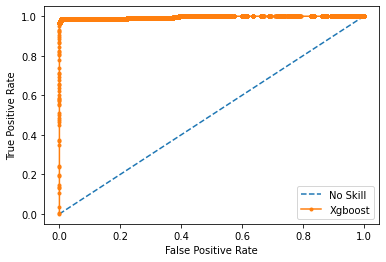

In [21]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



ns_probs = [0 for _ in range(len(Y_test1))]
# fit a model
model = boost
model.fit(X_train1, Y_train1)
# predict probabilities
lr_probs = model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test1, ns_probs)
lr_auc = roc_auc_score(Y_test1, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Xgboost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test1, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test1, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Xgboost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
DecisionTree: ROC AUC=0.984


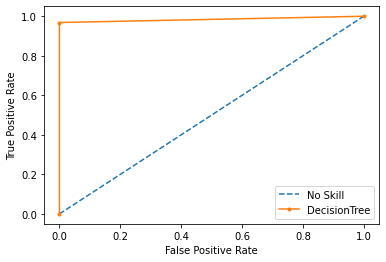

In [35]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



ns_probs = [0 for _ in range(len(Y_test1))]
# fit a model
model = clf_tree
model.fit(X_train1, Y_train1)
# predict probabilities
lr_probs = model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test1, ns_probs)
lr_auc = roc_auc_score(Y_test1, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DecisionTree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test1, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test1, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [37]:
print(lr_prob)

[False False False ... False False False]


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:10:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9954619521666204


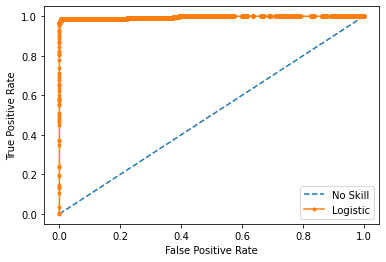

In [22]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# curve 
# fit a model
model = boost
model.fit(X_train1, Y_train1)
# predict probabilities
lr_probs = model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(Y_test1, lr_probs)
print(lr_auc)

# predict probabilities
yhat = model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test1, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Xgboost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()




[00:12:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Threshold=0.000321, G-Mean=0.990


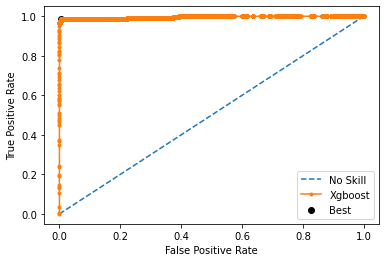

In [27]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
model = boost
model.fit(X_train1, Y_train1)
yhat = model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test1, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Xgboost')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [29]:
from sklearn.metrics import precision_recall_curve
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test1, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
print(ix)

Best Threshold=0.000321
448


In [30]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(Y_test1, yhat)

# Graphique AUC sur car désésquilibre important

No Skill PR AUC: 0.000


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[23:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgboost PR AUC: 0.973


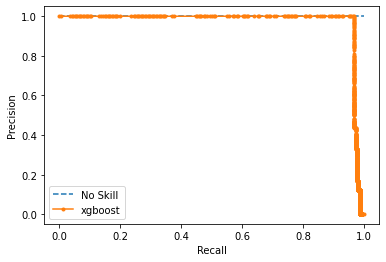

In [24]:
# pr curve and pr auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
 
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs,name):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(testy, model_probs)
	pyplot.plot(recall, precision, marker='.', label=name)
	# axis labels
	pyplot.xlabel('Recall')
	pyplot.ylabel('Precision')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
 

trainX, testX, trainy, testy = X_train1, X_test1, Y_train1, Y_test1
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
model = boost
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
auc_score = auc(recall, precision)
print('Xgboost PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(testy, model_probs,'xgboost')

No Skill PR AUC: 0.000
decision_tree PR AUC: 0.971


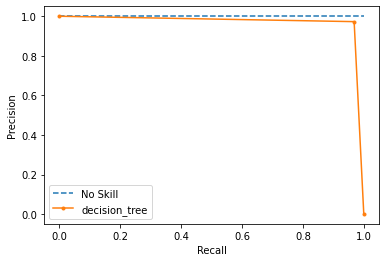

In [26]:
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
model = clf_tree
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
auc_score = auc(recall, precision)
print('decision_tree PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(testy, model_probs,'decision_tree')

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[23:54:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill ROC AUC 0.995


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[23:55:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgboost ROC AUC 0.995


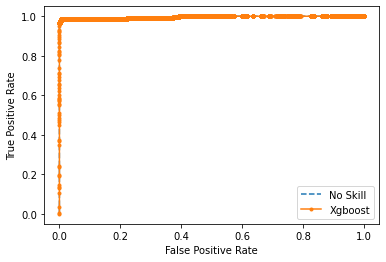

In [28]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
 
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs,name):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label=name)
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
 

model = boost
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, naive_probs)
print('No Skill ROC AUC %.3f' % roc_auc)
# skilled model
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, model_probs)
print('Xgboost ROC AUC %.3f' % roc_auc)
# plot roc curves
plot_roc_curve(testy, naive_probs, model_probs,'Xgboost')

Decision_tree ROC AUC 0.984


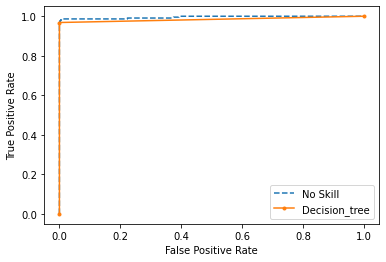

In [29]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
 
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs,name):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label=name)
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
 

model = clf_tree
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, model_probs)
print('Decision_tree ROC AUC %.3f' % roc_auc)
# plot roc curves
plot_roc_curve(testy, naive_probs, model_probs,'Decision_tree')